In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import itertools
import sys
import os
import math
sys.path.append('../..')
from joblib import Parallel, delayed
from functools import partial
from hyperopt import hp, tpe, fmin, Trials
from models.optim.seir_testing_dis import SEIR_Testing
from utils.optim.seir_testing.objective_functions import *
from utils.optim.seir_testing.optimization_methods import *
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


50.57596114960715 0.13132901351786347 64.4 2.447169531714302


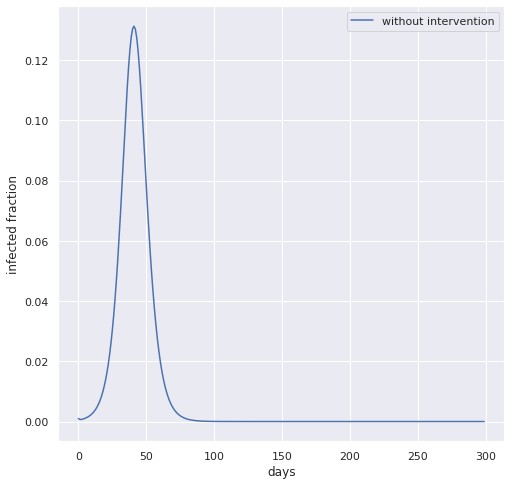

In [12]:
days = 300
grad1, states_base = calculate_opt(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
height = calculate_opt_height(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
time = calculate_opt_time(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
burden = calculate_opt_burden(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days, capacity=np.array([0.05]))
print(grad1, height, time, burden)
ind = np.arange(days)   # the x locations for the groups
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[2], label='without intervention')
plt.ylabel('infected fraction')
plt.xlabel('days')
plt.legend()
plt.show()

## Bayesian + Grid Search

40
100%|██████████| 500/500 [00:06<00:00, 76.41trial/s, best loss: 0.03637103566141403]
{'choice_array': array([0.5]), 'start_array': array([-4]), 'duration_array': array([120])}
19.017542101652385 0.03637103566141403 115.7 0.0


/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


926
100%|██████████| 1000/1000 [00:20<00:00, 48.21trial/s, best loss: 0.0375550684797265]
{'choice_array': array([0.5, 0.5]), 'start_array': array([ 9, 88]), 'duration_array': array([70, 50])}
18.71504121089066 0.0375550684797265 93.3 0.0


/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


399
100%|██████████| 1500/1500 [00:48<00:00, 30.93trial/s, best loss: 0.03782836766777185]
{'choice_array': array([0.5, 1. , 0.5]), 'start_array': array([ 10, 121, 199]), 'duration_array': array([70, 10, 30])}
21.128603027169685 0.03782836766777185 96.8 0.0


/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


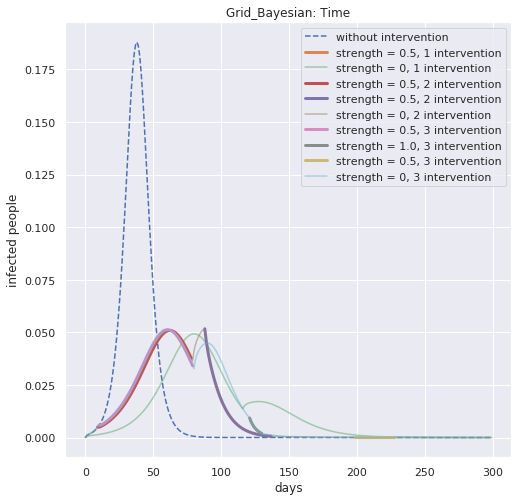

In [18]:
days = 300

def get_stats(min_params, params=None):
    val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days, params=params)
    height = calculate_opt_height(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
                  intervention_choice=min_params['choice_array'], days=days, params=params)
    time = calculate_opt_time(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
                  intervention_choice=min_params['choice_array'], days=days, params=params)
    burden = calculate_opt_burden(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
                  intervention_choice=min_params['choice_array'], days=days, params=params)
    print(val, height, time, burden)
    return(states)

def get_plot(states, fig, num, min_params=None):
    ind = np.arange(len(states[1]))
    ax = fig.add_subplot(1, 1, 1)
    if(not num):
        ax.plot(ind, states[1], label='without intervention', linestyle='dashed')
    else:
        k = len(min_params['start_array'])
        for i in range(k):
            xi = ind[min_params['start_array'][i]:min_params['start_array'][i]+min_params['duration_array'][i]]
            yi = states[1][min_params['start_array'][i]:min_params['start_array'][i]+min_params['duration_array'][i]]
            choice = min_params['choice_array'][i]
            ax.plot(xi, yi, label='strength = '+str(choice)+', '+str(num)+' intervention', linewidth=3)
        ax.plot(ind, states[1], alpha=0.5, label='strength = 0, '+str(num)+' intervention')
    ax.set_ylabel('infected people')
    ax.set_xlabel('days')
    ax.set_title('Grid_Bayesian: Time')
    ax.legend()
    return(fig)

#num_int=1
params=params_dict
_, min_params = grid_search(num_int=1, days=days, objective='height', sir_init=params, total_resource=0.2*days)
min_params = tpe_grid(num_int=1, days=days, min_params=min_params, objective='height', iters=500, sir_init=params, total_resource=0.2*days)
print(min_params)
states = get_stats(min_params, params)

fig = plt.figure(figsize=(8, 8))
fig = get_plot(fig=fig,states=states_base,num=0)
fig = get_plot(fig=fig,states=states,num=1,min_params=min_params)

#num_int = 2
_, min_params = grid_search(num_int=2, days=days, objective='height', sir_init=params, total_resource=0.2*days)
min_params = tpe_grid(num_int=2, days=days, min_params=min_params, objective='height', iters=1000, sir_init=params, total_resource=0.2*days)
print(min_params)
states = get_stats(min_params, params=params)
fig = get_plot(fig=fig,states=states,num=2,min_params=min_params)

#num_int = 3
_, min_params = grid_search(num_int=3, days=days, objective='height', sir_init=params, total_resource=0.2*days)
min_params = tpe_grid(num_int=3, days=days, min_params=min_params, objective='height', iters=1500, sir_init=params, total_resource=0.2*days)
print(min_params)
states = get_stats(min_params, params=params)
fig = get_plot(fig=fig,states=states,num=3,min_params=min_params)

In [17]:
params_dict = {}
params_dict['T_inf'] = 3.2
params_dict['T_inc'] = 4.3
params_dict['P_severe'] = 0.78
params_dict['P_fatal'] = 0.05
params_dict['I_hosp_ratio'] = 0.3
params_dict['E_hosp_ratio'] = 0.1
params_dict['T_recov_severe'] = 10
params_dict['factor'] = 1.9/1.1